# Hossein Entezari Zarch
# Artificial Intelligence Course
## Deep Neural Netwok Computer Assignment with Pytorch
## 81096419

In [3]:
import os
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import random
from datetime import timedelta
from datetime import datetime

!pip install pytorch-model-summary
from pytorch_model_summary import summary

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

random.seed(1)
import numpy
numpy.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)


#Download Data:

In [4]:
!gdown --id '1aFjcSk9hBzsHusrjO3UjCg4xQo9Ubdr1'
!unzip 'categorized_products' -d ''

Downloading...
From: https://drive.google.com/uc?id=1aFjcSk9hBzsHusrjO3UjCg4xQo9Ubdr1
To: /content/categorized_products.zip
250MB [00:01, 131MB/s]
Archive:  categorized_products.zip
replace categorized_products/Accessory Gift Set/19929.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Part 1:
## Implementation:
In this part, we executed a for loop over the main directory and on each step we plotted the first picture in the directory with its folder name as title. So we plotted 12 picture of different labels in 3 rows.

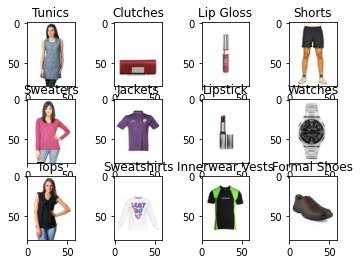

In [5]:
data_path = '/content/categorized_products'
for id, dir_name in enumerate(os.listdir(data_path)):
    if id > 11:
        break
    directory = os.path.join(data_path, dir_name)
    if not os.path.isdir(directory):
        continue
    for pic_name in os.listdir(directory):
        pic_dir = os.path.join(directory, pic_name)
        image = Image.open(pic_dir)
        plt.subplot(3, 4, id+1)
        plt.rcParams['figure.figsize'] = [12, 13]
        plt.title(dir_name)
        plt.imshow(image)
        plt.plot()
        break

#Part2:
##Implementation:
In this cell we made a loop over dataset and counted num of each label in dataset and after sorting the list in descending order, plot it in a bar graph syle.

In [10]:
class CustomToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""
    
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)

In [11]:
transform = transforms.Compose([transforms.Grayscale(),
                                CustomToTensor()
                               ]
                              ) ## composes multiple transforms into single one

dataset = ImageFolder(data_path, transform=transform)

0 Accessory Gift Set 111
1 Backpacks 722
2 Belts 813
3 Capris 175
4 Caps 283
5 Casual Shoes 2846
6 Clutches 290
7 Cufflinks 106
8 Deodorant 347
9 Dresses 464
10 Dupatta 116
11 Earrings 417
12 Flats 500
13 Flip Flops 916
14 Formal Shoes 637
15 Handbags 1757
16 Heels 1323
17 Innerwear Vests 241
18 Jackets 258
19 Jeans 608
20 Kajal and Eyeliner 102
21 Kurtas 1844
22 Kurtis 234
23 Leggings 177
24 Lip Gloss 144
25 Lipstick 315
26 Nail Polish 329
27 Necklace and Chains 160
28 Night suits 141
29 Nightdress 189
30 Pendant 175
31 Perfume and Body Mist 613
32 Ring 118
33 Sandals 897
34 Sarees 424
35 Scarves 117
36 Shirts 3213
37 Shorts 547
38 Skirts 128
39 Socks 686
40 Sports Shoes 2035
41 Sunglasses 1073
42 Sweaters 277
43 Sweatshirts 285
44 Ties 261
45 Tops 1762
46 Track Pants 303
47 Trousers 530
48 Tshirts 3534
49 Tunics 229
50 Wallets 936
51 Watches 2541


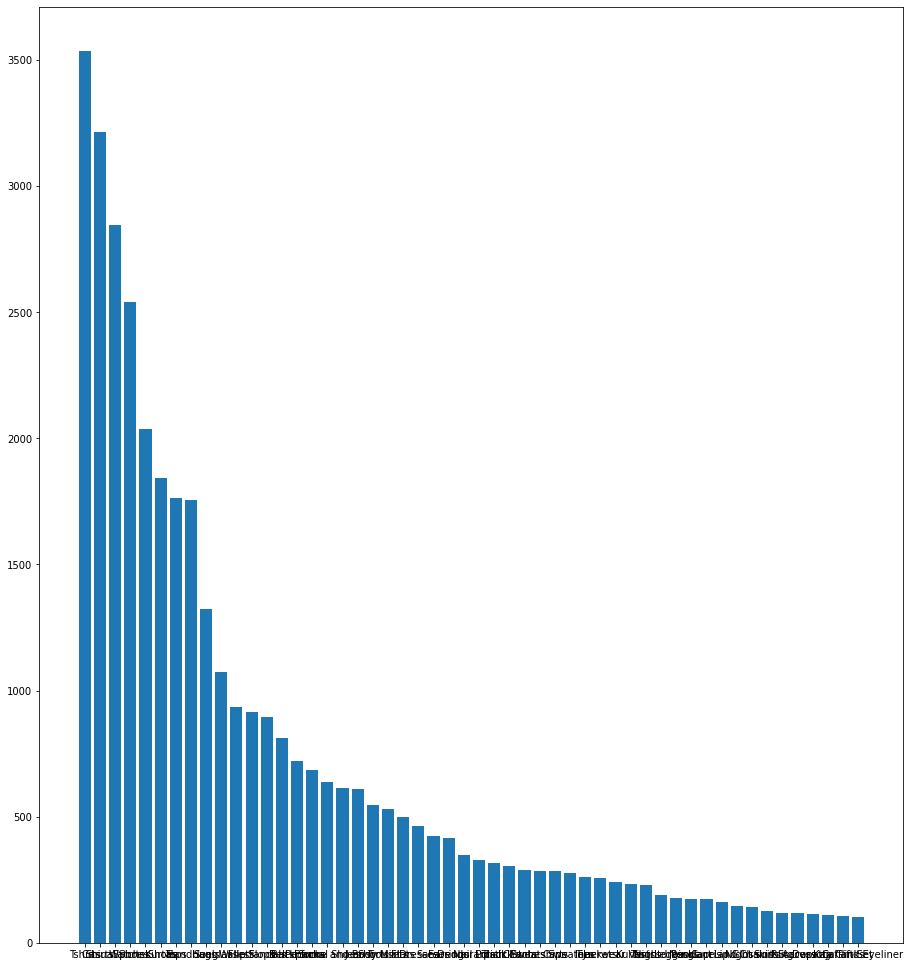

In [12]:
classes = dataset.classes
def get_number_distribution(dataset):
    classes = dataset.classes
    total_category_count = {label_class : 0 for label_class in classes}
    for id, dir_name in enumerate(os.listdir(data_path)):
        directory = os.path.join(data_path, dir_name)
        if not os.path.isdir(directory):
            continue
        for pic_name in os.listdir(directory):
            total_category_count[dir_name] += 1
    for i, item in enumerate(total_category_count):
        print(i, item, total_category_count[item])
    sorted_category_count_list = sorted(total_category_count.items(), key=lambda kv: kv[1])[::-1]
    return sorted_category_count_list

total_category_count = get_number_distribution(dataset)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([x[0] for x in total_category_count], [x[1] for x in total_category_count])
plt.show()

## Data Split:
In this part, in order to build the dataset in pytorch we defined 'ImgDS' class inherited from 'Dataset' class and defined some functions in it which makes it available for us to iterate over dataset by dataloader. Also we performed needed transformations in constructor function which makes images grayscale and store them on tensors.


In [13]:
class ImgDS(Dataset):
    def __init__(self, root_path, transform, train_subset=0.8):
        super().__init__()
        self.root_path = root_path
        self.train_subset = train_subset
        self.dir_list = []
        self.labels = []
        self.n_classes = 0
        self.label_mapper = []

        self.transform = transform
        for id, dir_name in enumerate(os.listdir(self.root_path)):
            self.label_mapper.append(dir_name)
            directory = os.path.join(self.root_path, dir_name)
            if not os.path.isdir(directory):
                continue
            for pic_name in os.listdir(directory):
                pic_dir = os.path.join(directory, pic_name)
                self.dir_list.append(pic_dir)
                self.labels.append(id)
            self.n_classes += 1
        
        tmp = list(zip(self.dir_list, self.labels))
        random.shuffle(tmp)
        self.dir_list, self.labels = zip(*tmp)
        # self.labels = torch.Tensor(self.labels)
        print('label_mapper', self.label_mapper)
        
    def __len__(self):
        return len(self.dir_list)
    
    def __read_image__(self, name):
        image = Image.open(name)
        image = self.transform(image)
        return image

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()[0]
        pic_name = self.dir_list[idx]
        image = self.__read_image__(pic_name)
        label = self.labels[idx]
        return image, label

## Split Data by Category:
In order to perform the split data in each category by given ratio we defined function 'get_train_test_indices' which gives the dataset as input and by iterate several times over dataset, gives indices of train and test dataset on output which preserves the given ratio in each category.

In [14]:
def get_train_test_indices(dataset, test_ratio = 0.2):
    classes = []
    for x, y in dataset:
        if y not in classes:
            classes.append(y)
    category_counts = {label : 0 for label in classes}
    for x, y in dataset:
        category_counts[y] += 1
    test_counts = {label : 0 for label in classes}
    test_indices = []
    train_indices = []
    for i, (_, y) in enumerate(dataset):
        if test_counts[y] < test_ratio * category_counts[y]:
            test_indices.append(i)
            test_counts[y] += 1
            continue
        train_indices.append(i)
    random.shuffle(train_indices)
    random.shuffle(test_indices)
    return train_indices, test_indices

# Feed Forward Network:
## Implementation:
In this part we defined our Feedforward_net inherited from nn.Module which gives model dimentions as its constructor input and generates the feedforward network we want with respect to the elements stored on its input.
## Summary Function:
This function gives us number of weights in each layer of our network and finally total number of these weights.

In [15]:
class Feedforward_net(nn.Module):

    def __init__(self, network_dims, activation=None):
        super().__init__()
        self.dims = network_dims
        self.activation = activation
        self.layers = nn.ModuleList([nn.Linear(self.dims[i], self.dims[i+1]) for i in range(len(self.dims)-2)])
        self.last_fc = nn.Linear(self.dims[-2], self.dims[-1])

    def forward(self, X):
        batch_size = X.shape[0]
        X = X.view(-1, self.dims[0])
        for layer in self.layers:
            X = layer(X)
            if self.activation == None:
                X = F.relu(X)
            elif self.activation == "leakyRelu":
                X = F.leaky_relu(X)
            elif self.activation == "tanh":
                X = torch.tanh(X)
        X = self.last_fc(X)
        return X
    
    def summary(self):
        print(summary(Feedforward_net(self.dims), torch.zeros((1, 4800))))

## Base Configurations:
As the base configuration we have in hyperparameters and defining the dataloaders, these was performed below. Also the loss function are defined and the device was set to 'cuda' if it is available to perform the calculations.

In [16]:
batch_size = 64
base_transform = transforms.Compose([transforms.Grayscale(),
                                CustomToTensor()
                               ])
dataset = ImgDS(data_path, base_transform)
n_classes = dataset.n_classes

train_indices, test_indices = get_train_test_indices(dataset)
train_data_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices), drop_last=True)
test_data_loader = DataLoader(Subset(dataset, test_indices), batch_size=batch_size, drop_last=False)

n_epochs = 10
learning_rate = 0.01
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

label_mapper ['Tunics', 'Clutches', 'Lip Gloss', 'Shorts', 'Sweaters', 'Jackets', 'Lipstick', 'Watches', 'Tops', 'Sweatshirts', 'Innerwear Vests', 'Formal Shoes', 'Socks', 'Sports Shoes', 'Tshirts', 'Shirts', 'Handbags', 'Capris', 'Accessory Gift Set', 'Cufflinks', 'Caps', 'Skirts', 'Necklace and Chains', 'Kurtis', 'Backpacks', 'Wallets', 'Belts', 'Pendant', 'Jeans', 'Dresses', 'Earrings', 'Perfume and Body Mist', 'Ties', 'Flip Flops', 'Kajal and Eyeliner', 'Nail Polish', 'Scarves', 'Sarees', 'Track Pants', 'Trousers', 'Ring', 'Nightdress', 'Sandals', 'Casual Shoes', 'Leggings', 'Flats', 'Night suits', 'Heels', 'Sunglasses', 'Kurtas', 'Dupatta', 'Deodorant']


# Train Fuctions:
In this part we defined some functions needed to train a model and evaluate its performance on labeling the data.
## Train Function:
We defined the function 'train' gives a model and a data loader as its input and train the model in given epoch num and also shows the loss on each step and the time consumed the model to be trained.

In [17]:
def train(model, optimizer, data_loader, device=device, criterion=criterion, n_epoch=10):
    total_time = 0  
    losses = []
    model.train()
    for epoch in range(n_epoch):
        epoch_loss = 0
        d1 = datetime.now()
        model.train()
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = model(images)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()    
        
        average_loss = epoch_loss/len(data_loader)
        losses.append(average_loss)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
    print('total training time: %.3f minutes' % (total_time / 60))
    return losses

## Plot Losses and Accuracies
We defined two function which gives the losses and accuracies per class as their input and plot it in a comprehensive way.

In [18]:
def plot_train_losses(losses):
    fig = plt.figure(figsize=(40, 3))
    ax = fig.add_axes([0,0,0.1,1])
    ax.bar([x+1 for x in range(len(losses))], losses)
    plt.show()


def plot_per_class_accuracy(train_accuracies, test_accuracies, dataset=dataset):
    ax = plt.subplot(111)
    w = 0.3
    x = np.arange(len(train_accuracies))
    ax.bar(x-w/2, train_accuracies, width=w, color='b', align='center')
    ax.bar(x+w/2, test_accuracies, width=w, color='r', align='center')
    ax.set_xticklabels(dataset.label_mapper)
    plt.show()

## Get Per Class Accuracy Function:
The function is defined in order to gives us the per class accuracy list on both train and test dataset and also it calculates the total accuracy of the model on both the train and test dataset. It gives the model, the train and test dataloaders and num of classes as its input to perform these processes. This function at first calculates the confusion matrix and utilizes it for latter computations.

In [20]:
def get_per_class_accuracy(model, train_data_loader=train_data_loader, test_data_loader=test_data_loader, n_classes=n_classes):

    train_confusion_matrix = torch.zeros(n_classes, n_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    train_confusion_matrix[t.long(), p.long()] += 1
    train_accuracies = train_confusion_matrix.diag()/train_confusion_matrix.sum(1)
    train_total_accuracy = train_confusion_matrix.diag().sum(0)/train_confusion_matrix.sum(1).sum(0)
    
    test_confusion_matrix = torch.zeros(n_classes, n_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    test_confusion_matrix[t.long(), p.long()] += 1
    test_accuracies = test_confusion_matrix.diag()/test_confusion_matrix.sum(1)
    test_total_accuracy = test_confusion_matrix.diag().sum(0)/test_confusion_matrix.sum(1).sum(0)

    return train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, train_confusion_matrix, test_confusion_matrix

## Model:
The model is constructed with respect to the given dimensions given to it as input and it is moved to the cuda if it had been available.
# Part3:
Hyperparameters: To achieve a model with high amount of accuracy, we examined different size of layers and num of layers and found an efficient configuration for the model hyperparameters, so at last we chose num of model layer to be 4 and its dimentions to be 4800 in the input layer layer and 12000, 7200 in hidden layers and 52 also on the output layer to choose between available classes.

Num of Weights: We have a four layer network an input layer and two hidden layers and an output layer, so we have totally 3 fully connected between every two neighbour layers, and a fully connected that connects a layer with M nodes to a layer with N nodes, would have M*N weights and if the fully connected has bias, it has one bias weight for each output node totally the network would have (M+1)*N weights. So here the first Linear layer has (4800+1)*12000 an the second Linear layer has (12000+1)*7200 and the third layer has (7200+1)*52 weights and in sum the model would have 17,409,652 trainable weights.

Loss Values: We see that on all epochs the average loss value is 'nan' which I think means that loss value is greater than the range value that the tensor elements can store in pytorch and also the final trained model works too bad and we conclude the model has learned nothing in the training process.

label_mapper ['Tunics', 'Clutches', 'Lip Gloss', 'Shorts', 'Sweaters', 'Jackets', 'Lipstick', 'Watches', 'Tops', 'Sweatshirts', 'Innerwear Vests', 'Formal Shoes', 'Socks', 'Sports Shoes', 'Tshirts', 'Shirts', 'Handbags', 'Capris', 'Accessory Gift Set', 'Cufflinks', 'Caps', 'Skirts', 'Necklace and Chains', 'Kurtis', 'Backpacks', 'Wallets', 'Belts', 'Pendant', 'Jeans', 'Dresses', 'Earrings', 'Perfume and Body Mist', 'Ties', 'Flip Flops', 'Kajal and Eyeliner', 'Nail Polish', 'Scarves', 'Sarees', 'Track Pants', 'Trousers', 'Ring', 'Nightdress', 'Sandals', 'Casual Shoes', 'Leggings', 'Flats', 'Night suits', 'Heels', 'Sunglasses', 'Kurtas', 'Dupatta', 'Deodorant']
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1          [1, 12000]      57,612,000      57,612,000
          Linear-2           [1, 7200]      86,407,200      86,407,200
          Linear-3             [1, 52]         3

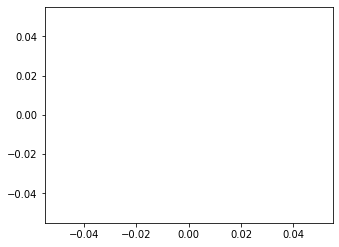

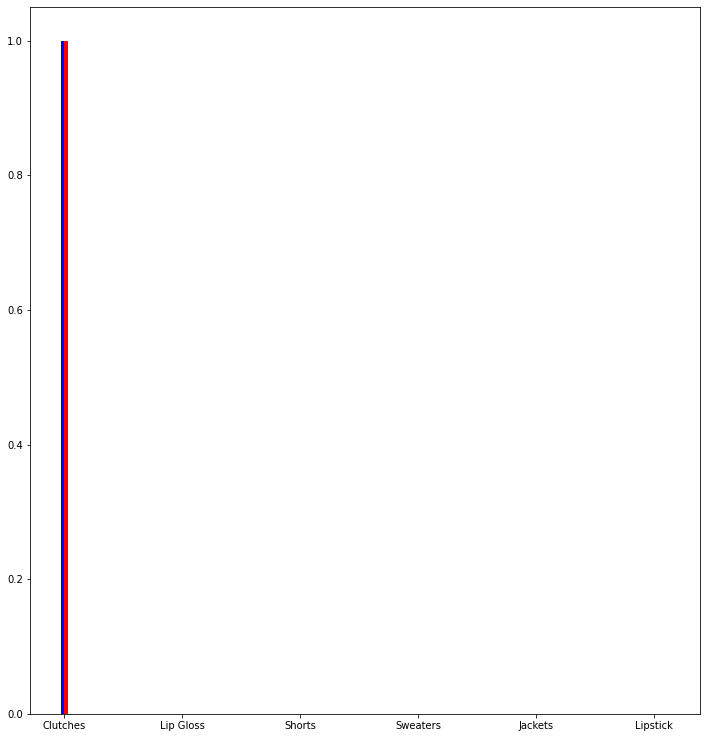

In [21]:
base_transform = transforms.Compose([transforms.Grayscale(),
                                CustomToTensor()
                               ])
dataset = ImgDS(data_path, base_transform)
n_classes = dataset.n_classes

train_indices, test_indices = get_train_test_indices(dataset)
train_data_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices), drop_last=True)
test_data_loader = DataLoader(Subset(dataset, test_indices), batch_size=batch_size, drop_last=False)

model1 = Feedforward_net([4800, 12000, 7200, 52])
model1.summary()

criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)
model1 = model1.to(device)
losses1 = train(model1, optimizer1, train_data_loader)

train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model1)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses1)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# Part4:
## Normalization:
Implementation: In order to normalize input data we use ToTensor() instead of CustomToTensor() in tranforms and it performs the normalization in addition to the store the data in tensors. This transform scales input pictures pixel values to a value between zero and one.

Analysis: In this we simply observe that unlike what happened in previous part, the loss value decreases among epoch which means that the model is learning information from dataset. Also in final model of this part we see a dramatic change compared to model trained in preivous part, the accuracy of model in part 3 was about 0.3% but in this part the accuracy increased to about 67% on both train and test dataset. This comparison clearly shows us the critical role that data normalization plays in these networks.



label_mapper ['Tunics', 'Clutches', 'Lip Gloss', 'Shorts', 'Sweaters', 'Jackets', 'Lipstick', 'Watches', 'Tops', 'Sweatshirts', 'Innerwear Vests', 'Formal Shoes', 'Socks', 'Sports Shoes', 'Tshirts', 'Shirts', 'Handbags', 'Capris', 'Accessory Gift Set', 'Cufflinks', 'Caps', 'Skirts', 'Necklace and Chains', 'Kurtis', 'Backpacks', 'Wallets', 'Belts', 'Pendant', 'Jeans', 'Dresses', 'Earrings', 'Perfume and Body Mist', 'Ties', 'Flip Flops', 'Kajal and Eyeliner', 'Nail Polish', 'Scarves', 'Sarees', 'Track Pants', 'Trousers', 'Ring', 'Nightdress', 'Sandals', 'Casual Shoes', 'Leggings', 'Flats', 'Night suits', 'Heels', 'Sunglasses', 'Kurtas', 'Dupatta', 'Deodorant']
epoch 1, train_loss: 2.580, time elapsed: 17.699375 seconds
epoch 2, train_loss: 1.776, time elapsed: 17.839668 seconds
epoch 3, train_loss: 1.500, time elapsed: 17.718708 seconds
epoch 4, train_loss: 1.363, time elapsed: 17.768203 seconds
epoch 5, train_loss: 1.264, time elapsed: 17.978575 seconds
epoch 6, train_loss: 1.200, time 

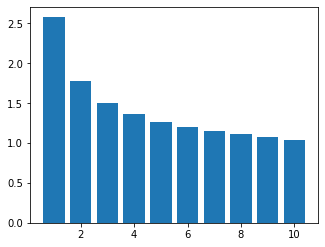

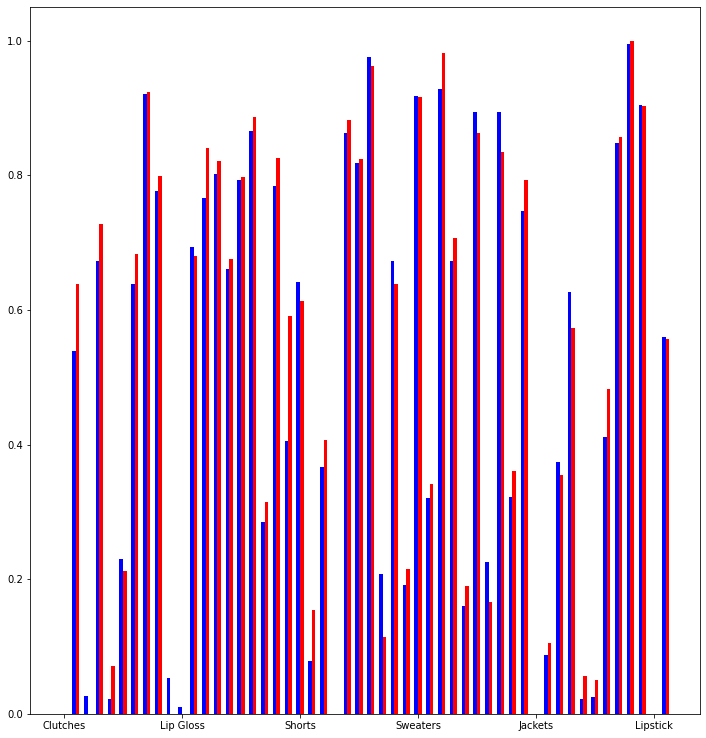

In [22]:
norm_transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor()
                               ])
dataset = ImgDS(data_path, norm_transform)
n_classes = dataset.n_classes

train_indices, test_indices = get_train_test_indices(dataset)
train_data_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices), drop_last=True)
test_data_loader = DataLoader(Subset(dataset, test_indices), batch_size=batch_size, drop_last=False)

model2 = Feedforward_net([4800, 12000, 7200, 52])

optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)
model2 = model2.to(device)
losses2 = train(model2, optimizer2, train_data_loader)


train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model2)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses2)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# Part5:
## Init weights function:
Implementation: In order to initialize the network weights with zero, the 'init_weights' function is defined which gives a network as input and performs the initialization on its weights. The function is  passed to the 'apply' function called on model so it performs the initialization recursively on each network and its children.

Analysis: In this model with weights initialized az zero the weights are never updated and remains zero, also the loss value remains the same value which is reasonable with respect to the computation crossEntropyLoss performs and the fact that all of the output values are always zero. In comparison with previous model, we see that, here loss value does not decreases and remains unchanged and the model does not converge to a more efficient state and does not learn any information, this obsevation shows us that model with initialized weights az zero learns nothing.

Best Initial State: I believe that, every state of the weight values stores a load of information, and we aim to change this information during learning process in a way that loss value decreases as much as possible with gradient descent, so I think when weights having a uniform distribution on values so much near zero, they would be able to be updated through learning process in an efficient way and they contain no information with having this distribution on the inital state, the reason for saying weight values be near zero is that, we expect nonlinear functionality from activation functions and most of them have their most nonlinear region for values near zero, so with having weight values near zero, we would be able use these nonlinear functionality of activation functions as much as possible.




epoch 1, train_loss: 3.896, time elapsed: 17.852225 seconds
epoch 2, train_loss: 3.798, time elapsed: 17.84292 seconds
epoch 3, train_loss: 3.720, time elapsed: 17.883176 seconds
epoch 4, train_loss: 3.661, time elapsed: 17.850167 seconds
epoch 5, train_loss: 3.616, time elapsed: 17.977479 seconds
epoch 6, train_loss: 3.582, time elapsed: 17.794311 seconds
epoch 7, train_loss: 3.557, time elapsed: 17.732151 seconds
epoch 8, train_loss: 3.538, time elapsed: 17.724425 seconds
epoch 9, train_loss: 3.523, time elapsed: 17.874607 seconds
epoch 10, train_loss: 3.512, time elapsed: 17.798395 seconds
total training time: 2.972 minutes
>>>>>>>>total accuracy on train data is 0.095 and on test data is 0.095


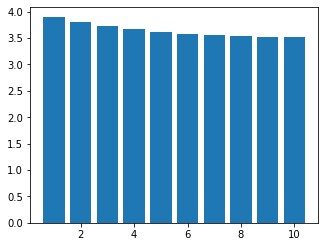

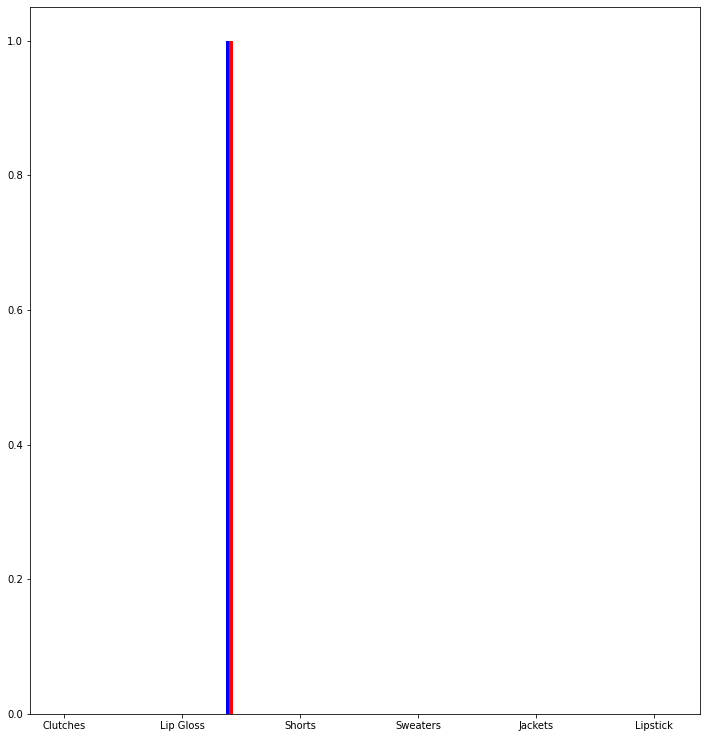

In [23]:
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
        m.bias.data.fill_(0)

model3 = Feedforward_net([4800, 12000, 7200, 52])

optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01)
model3 = model3.to(device)
model3.apply(init_weights)
losses3 = train(model3, optimizer3, train_data_loader)

train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model3)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses3)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# Part6:
## Learning Rate Anaylsis
High value for learning rate: In model with learning rate of 1 we see that, loss value does not decrease approximately and loss value after first epoch has little difference with loss value after last epoch and sometimes may the loss value make a huge jump up, the reason of these observation is that, with a high value of learning rate, converging to a local optimum is harder and most of time when updating wights the model would jump over that local point and maybe get more distance from that local optimum point.

Tiny value for learning rate: In models with relatively little value for learning rate we clearly see that model converge so slowly to an optimum and this causes model be trained so late with the need of a high number of train steps.

Result of different values for learning rate: With the learning rate of 1 as a high value for learning rate we see that always the loss value is nan and the model is learning no information. The learning rate of 0.1 is almost high also because it gave us accuracy about 7% lower than the accuracy we gave from learning rate 0.01. Also 0.001 and 0.0001 as learning rate values gave us lower accuracies because these values are not great enough to learn the model in 10 epochs.

High and Low values for learning rate: We know that having neither a small or great value for learning rate causes the model to not learn well, because a low value of learning rate causes model converges to a local optimum too slow, and also a high value for learning rate does not allow the model converge to a local optimum and causes the model to just jump between different parts of the function space it searches on and it can not target a local optimum to converge.

Best Found Value For learning rate: with a search and experiment some values on different learning rate it was found that being equal to 0.04 for learning rate suffices and outcomes a model with about 72% of accuracy which is the highest result we have found ever.



epoch 1, train_loss: nan, time elapsed: 17.765219 seconds
epoch 2, train_loss: nan, time elapsed: 17.823031 seconds
epoch 3, train_loss: nan, time elapsed: 17.669822 seconds
epoch 4, train_loss: nan, time elapsed: 17.624362 seconds
epoch 5, train_loss: nan, time elapsed: 17.832297 seconds
epoch 6, train_loss: nan, time elapsed: 17.834954 seconds
epoch 7, train_loss: nan, time elapsed: 17.692066 seconds
epoch 8, train_loss: nan, time elapsed: 17.665117 seconds
epoch 9, train_loss: nan, time elapsed: 17.656159 seconds
epoch 10, train_loss: nan, time elapsed: 17.656885 seconds
total training time: 2.954 minutes
learning_rate =  1
>>>>>>>>total accuracy on train data is 0.006 and on test data is 0.006


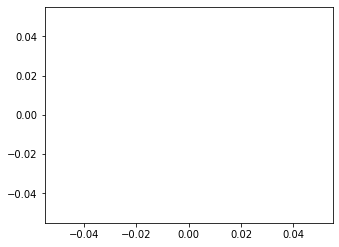

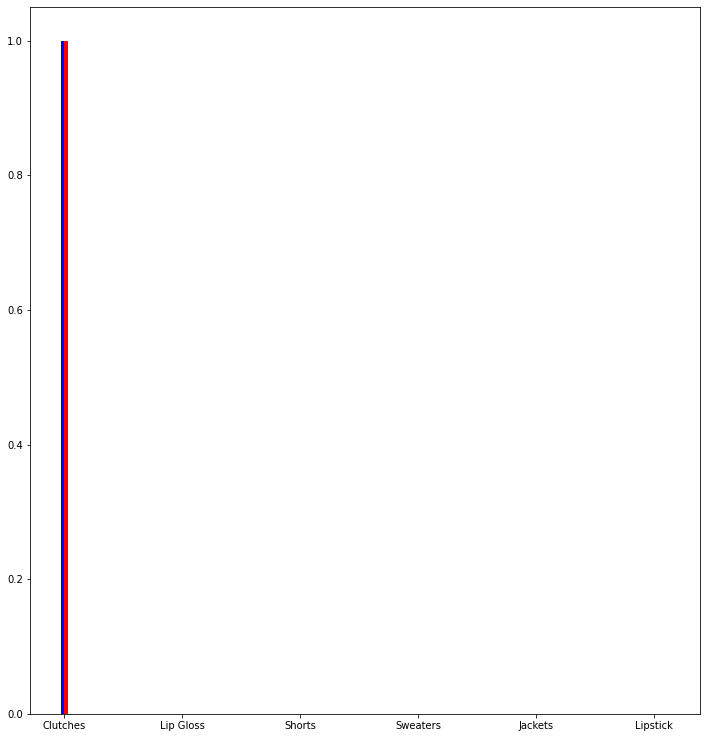

epoch 1, train_loss: 2.997, time elapsed: 18.031338 seconds
epoch 2, train_loss: 2.114, time elapsed: 18.153964 seconds
epoch 3, train_loss: 1.710, time elapsed: 18.087189 seconds
epoch 4, train_loss: 1.530, time elapsed: 18.194528 seconds
epoch 5, train_loss: 1.325, time elapsed: 18.15888 seconds
epoch 6, train_loss: 1.265, time elapsed: 18.04375 seconds
epoch 7, train_loss: 1.128, time elapsed: 18.107091 seconds
epoch 8, train_loss: 1.081, time elapsed: 18.109421 seconds
epoch 9, train_loss: 1.017, time elapsed: 18.220876 seconds
epoch 10, train_loss: 0.970, time elapsed: 18.089417 seconds
total training time: 3.020 minutes
learning_rate =  0.1
>>>>>>>>total accuracy on train data is 0.669 and on test data is 0.675


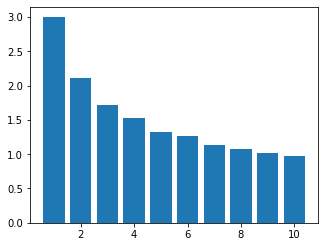

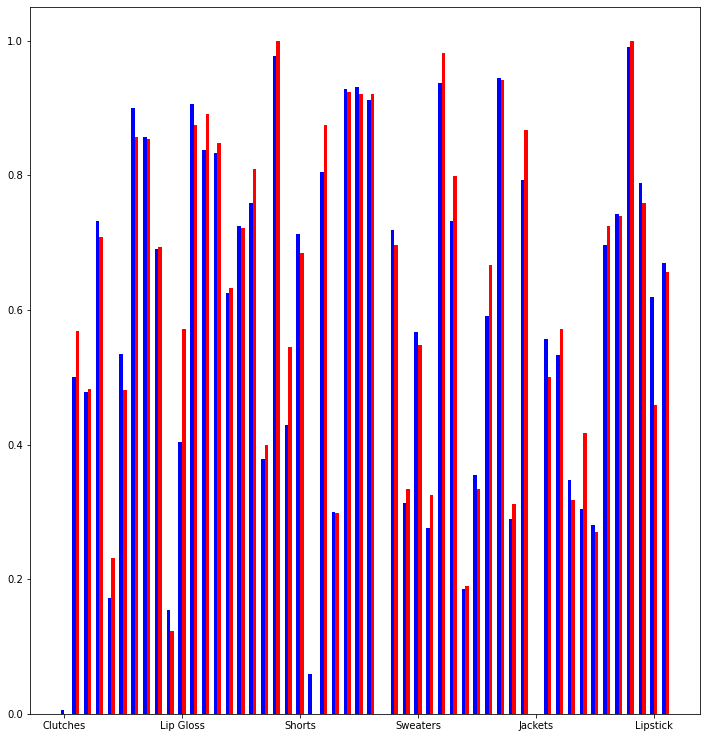

epoch 1, train_loss: 2.579, time elapsed: 17.971456 seconds
epoch 2, train_loss: 1.765, time elapsed: 17.775895 seconds
epoch 3, train_loss: 1.503, time elapsed: 17.790774 seconds
epoch 4, train_loss: 1.354, time elapsed: 17.709208 seconds
epoch 5, train_loss: 1.262, time elapsed: 17.78073 seconds
epoch 6, train_loss: 1.201, time elapsed: 17.732312 seconds
epoch 7, train_loss: 1.149, time elapsed: 17.864706 seconds
epoch 8, train_loss: 1.110, time elapsed: 17.885921 seconds
epoch 9, train_loss: 1.070, time elapsed: 17.86066 seconds
epoch 10, train_loss: 1.043, time elapsed: 17.864679 seconds
total training time: 2.971 minutes
learning_rate =  0.01
>>>>>>>>total accuracy on train data is 0.693 and on test data is 0.697


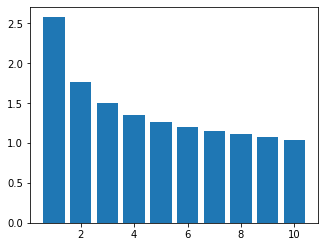

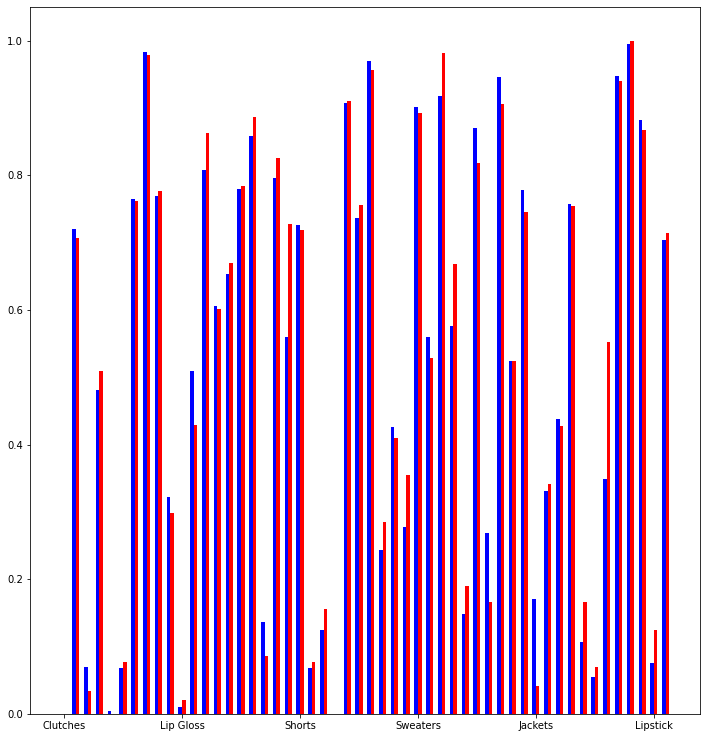

epoch 1, train_loss: 3.391, time elapsed: 18.035546 seconds
epoch 2, train_loss: 3.098, time elapsed: 17.992429 seconds
epoch 3, train_loss: 2.855, time elapsed: 18.039491 seconds
epoch 4, train_loss: 2.654, time elapsed: 18.01958 seconds
epoch 5, train_loss: 2.491, time elapsed: 18.055602 seconds
epoch 6, train_loss: 2.356, time elapsed: 18.033193 seconds
epoch 7, train_loss: 2.238, time elapsed: 18.280741 seconds
epoch 8, train_loss: 2.136, time elapsed: 18.029423 seconds
epoch 9, train_loss: 2.045, time elapsed: 18.034704 seconds
epoch 10, train_loss: 1.965, time elapsed: 18.036333 seconds
total training time: 3.009 minutes
learning_rate =  0.001
>>>>>>>>total accuracy on train data is 0.469 and on test data is 0.468


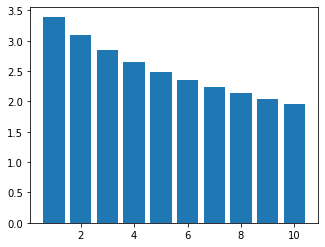

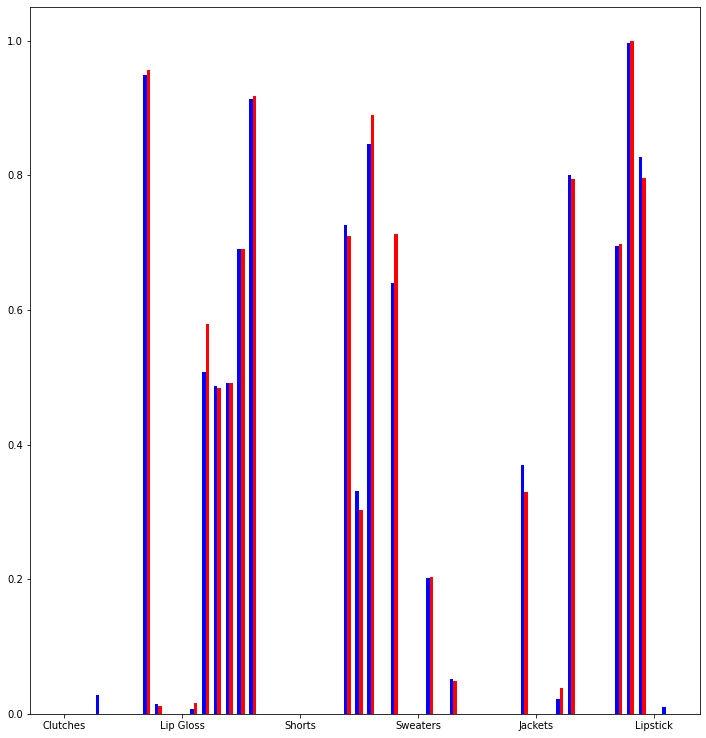

epoch 1, train_loss: 3.747, time elapsed: 18.088486 seconds
epoch 2, train_loss: 3.522, time elapsed: 18.070913 seconds
epoch 3, train_loss: 3.438, time elapsed: 18.241934 seconds
epoch 4, train_loss: 3.393, time elapsed: 18.109558 seconds
epoch 5, train_loss: 3.361, time elapsed: 18.116357 seconds
epoch 6, train_loss: 3.333, time elapsed: 18.102628 seconds
epoch 7, train_loss: 3.308, time elapsed: 18.141103 seconds
epoch 8, train_loss: 3.283, time elapsed: 18.096889 seconds
epoch 9, train_loss: 3.258, time elapsed: 18.115737 seconds
epoch 10, train_loss: 3.234, time elapsed: 17.992148 seconds
total training time: 3.018 minutes
learning_rate =  0.0001
>>>>>>>>total accuracy on train data is 0.203 and on test data is 0.197


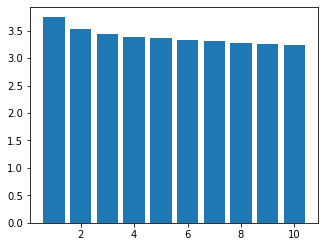

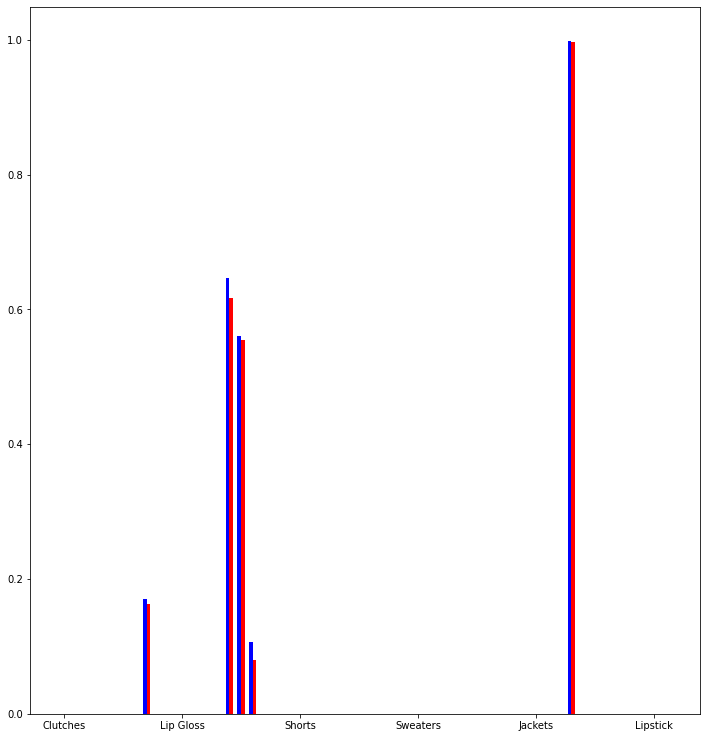

epoch 1, train_loss: 2.535, time elapsed: 18.066806 seconds
epoch 2, train_loss: 1.759, time elapsed: 18.27102 seconds
epoch 3, train_loss: 1.462, time elapsed: 18.06489 seconds
epoch 4, train_loss: 1.281, time elapsed: 18.091989 seconds
epoch 5, train_loss: 1.206, time elapsed: 18.038616 seconds
epoch 6, train_loss: 1.109, time elapsed: 17.973334 seconds
epoch 7, train_loss: 1.034, time elapsed: 18.058411 seconds
epoch 8, train_loss: 1.002, time elapsed: 17.961147 seconds
epoch 9, train_loss: 0.940, time elapsed: 17.949478 seconds
epoch 10, train_loss: 0.893, time elapsed: 18.025237 seconds
total training time: 3.008 minutes
learning_rate =  0.08
>>>>>>>>total accuracy on train data is 0.726 and on test data is 0.729


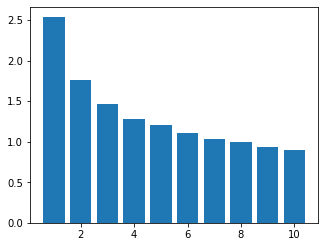

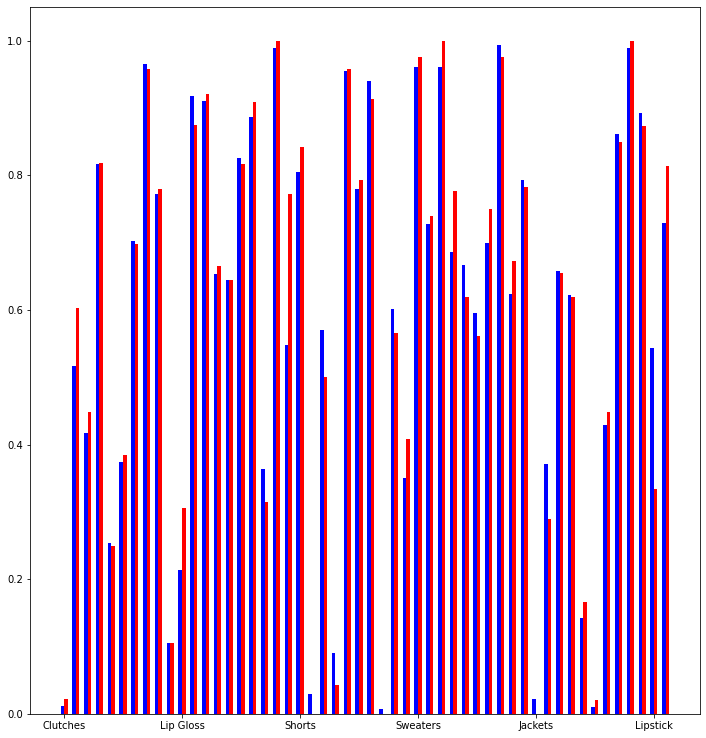

epoch 1, train_loss: 2.211, time elapsed: 17.950088 seconds
epoch 2, train_loss: 1.512, time elapsed: 18.003446 seconds
epoch 3, train_loss: 1.297, time elapsed: 18.074138 seconds
epoch 4, train_loss: 1.182, time elapsed: 17.918081 seconds
epoch 5, train_loss: 1.094, time elapsed: 17.906203 seconds
epoch 6, train_loss: 1.039, time elapsed: 17.962485 seconds
epoch 7, train_loss: 0.977, time elapsed: 18.088311 seconds
epoch 8, train_loss: 0.942, time elapsed: 18.226534 seconds
epoch 9, train_loss: 0.898, time elapsed: 17.917649 seconds
epoch 10, train_loss: 0.876, time elapsed: 17.969283 seconds
total training time: 3.000 minutes
learning_rate =  0.04
>>>>>>>>total accuracy on train data is 0.729 and on test data is 0.729


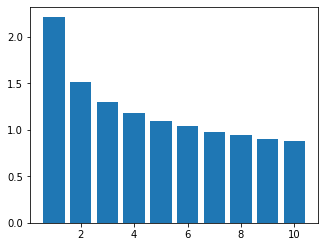

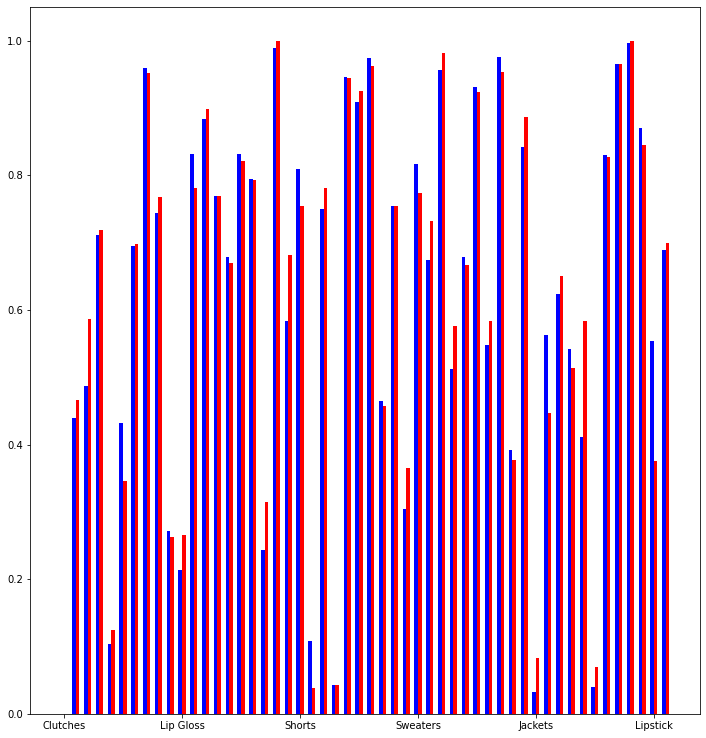

In [24]:
# #-------------------------------------------------------------------------------lr=1
model6 = Feedforward_net([4800, 12000, 7200, 52])

optimizer6 = torch.optim.SGD(model6.parameters(), lr=1)
model6 = model6.to(device)
losses6 = train(model6, optimizer6, train_data_loader)

print('learning_rate = ', 1)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model6)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses6)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# #-------------------------------------------------------------------------------lr=0.1
model6 = Feedforward_net([4800, 12000, 7200, 52])

optimizer6 = torch.optim.SGD(model6.parameters(), lr=0.1)
model6 = model6.to(device)
losses6 = train(model6, optimizer6, train_data_loader)

print('learning_rate = ', 0.1)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model6)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses6)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------lr=0.01
model6 = Feedforward_net([4800, 12000, 7200, 52])

optimizer6 = torch.optim.SGD(model6.parameters(), lr=0.01)
model6 = model6.to(device)
losses6 = train(model6, optimizer6, train_data_loader)

print('learning_rate = ', 0.01)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model6)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses6)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# #-------------------------------------------------------------------------------lr=0.001
model6 = Feedforward_net([4800, 12000, 7200, 52])

optimizer6 = torch.optim.SGD(model6.parameters(), lr=0.001)
model6 = model6.to(device)
losses6 = train(model6, optimizer6, train_data_loader)

print('learning_rate = ', 0.001)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model6)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses6)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# #-------------------------------------------------------------------------------lr=0.0001
model6 = Feedforward_net([4800, 12000, 7200, 52])

optimizer6 = torch.optim.SGD(model6.parameters(), lr=0.0001)
model6 = model6.to(device)
losses6 = train(model6, optimizer6, train_data_loader)

print('learning_rate = ', 0.0001)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model6)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses6)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------lr=0.08
model6 = Feedforward_net([4800, 12000, 7200, 52])

optimizer6 = torch.optim.SGD(model6.parameters(), lr=0.08)
model6 = model6.to(device)
losses6 = train(model6, optimizer6, train_data_loader)

print('learning_rate = ', 0.08)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model6)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses6)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------lr=0.04
model6 = Feedforward_net([4800, 12000, 7200, 52])

optimizer6 = torch.optim.SGD(model6.parameters(), lr=0.04)
model6 = model6.to(device)
losses6 = train(model6, optimizer6, train_data_loader)

print('learning_rate = ', 0.04)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model6)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses6)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# Part7:
## Batch Size:
Batch size analysis: In experiments below, you see that it seems in our model with the configuration it has change the batch size to 32 or 128 does not make any critical change or improvement in the accuracy and performance of the model, and model with trained with 32 of batch size gave almost the same accuracy and model with 128 of batch size gave us also a littel lower accuaracy.

Plus Points and Draw backs of big and small data batches: In general I think that with having a more value of batch size compared to a lower batch size, on each model update, the step we make in update would be more confident and this should cause the model learn better and faster and also we know that higher batch size needs bigger GPU and hardware. but the result we get here does not support this claim because larger batch size causes the gradients to be less noisy and this weakens the randomization factor we expect from the gradients in convergence to have, in order to converge to a more efficient local optimum. It has been shown that, larger values of batch size causes degradation in accuracy and quality we get.

Learning rate experiments: With the batch size of 128 when we examined lower and higher learning rate on both we got lower accuracy compared to the original learnging rate we had been found earlier and we conclude that change the learning can not cause the model better accuracy when we have destroyed model a little with larger batch size and the result of the learning rate change is just the same as the result we got from the models trained with batch size of 64.

label_mapper ['Tunics', 'Clutches', 'Lip Gloss', 'Shorts', 'Sweaters', 'Jackets', 'Lipstick', 'Watches', 'Tops', 'Sweatshirts', 'Innerwear Vests', 'Formal Shoes', 'Socks', 'Sports Shoes', 'Tshirts', 'Shirts', 'Handbags', 'Capris', 'Accessory Gift Set', 'Cufflinks', 'Caps', 'Skirts', 'Necklace and Chains', 'Kurtis', 'Backpacks', 'Wallets', 'Belts', 'Pendant', 'Jeans', 'Dresses', 'Earrings', 'Perfume and Body Mist', 'Ties', 'Flip Flops', 'Kajal and Eyeliner', 'Nail Polish', 'Scarves', 'Sarees', 'Track Pants', 'Trousers', 'Ring', 'Nightdress', 'Sandals', 'Casual Shoes', 'Leggings', 'Flats', 'Night suits', 'Heels', 'Sunglasses', 'Kurtas', 'Dupatta', 'Deodorant']
epoch 1, train_loss: 2.006, time elapsed: 21.491867 seconds
epoch 2, train_loss: 1.401, time elapsed: 21.596796 seconds
epoch 3, train_loss: 1.212, time elapsed: 21.634166 seconds
epoch 4, train_loss: 1.096, time elapsed: 21.498251 seconds
epoch 5, train_loss: 1.024, time elapsed: 21.622685 seconds
epoch 6, train_loss: 0.956, time 

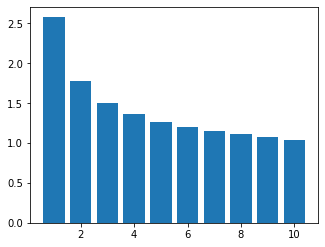

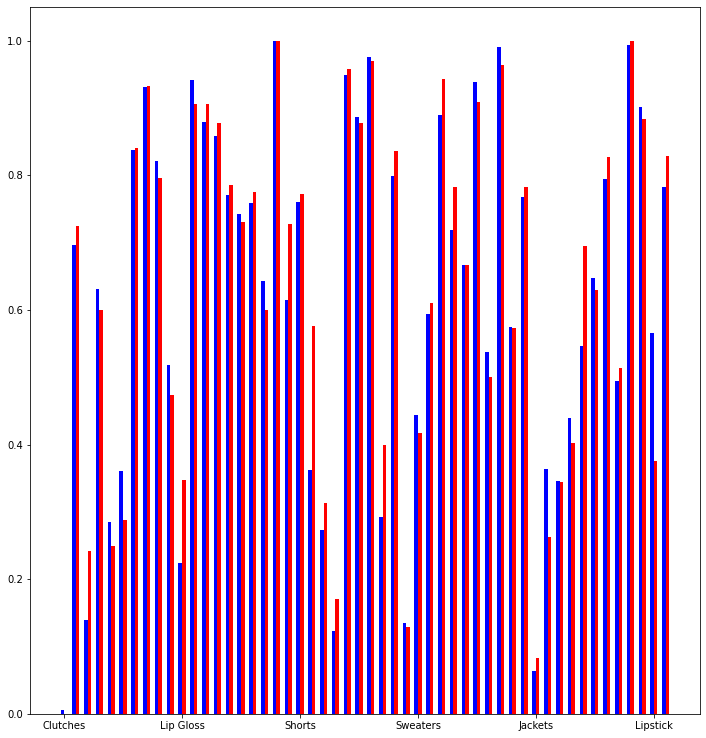

epoch 1, train_loss: 2.474, time elapsed: 16.163406 seconds
epoch 2, train_loss: 1.740, time elapsed: 16.083788 seconds
epoch 3, train_loss: 1.481, time elapsed: 16.120994 seconds
epoch 4, train_loss: 1.346, time elapsed: 16.272639 seconds
epoch 5, train_loss: 1.244, time elapsed: 16.156911 seconds
epoch 6, train_loss: 1.169, time elapsed: 16.002333 seconds
epoch 7, train_loss: 1.115, time elapsed: 16.094515 seconds
epoch 8, train_loss: 1.078, time elapsed: 15.970433 seconds
epoch 9, train_loss: 1.022, time elapsed: 16.197421 seconds
epoch 10, train_loss: 1.007, time elapsed: 15.926141 seconds
total training time: 2.683 minutes
batch size =  128  learning rate =  0.04
>>>>>>>>total accuracy on train data is 0.655 and on test data is 0.663


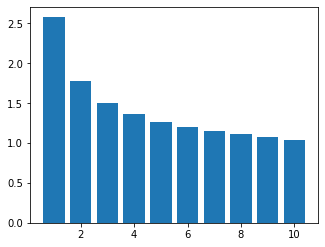

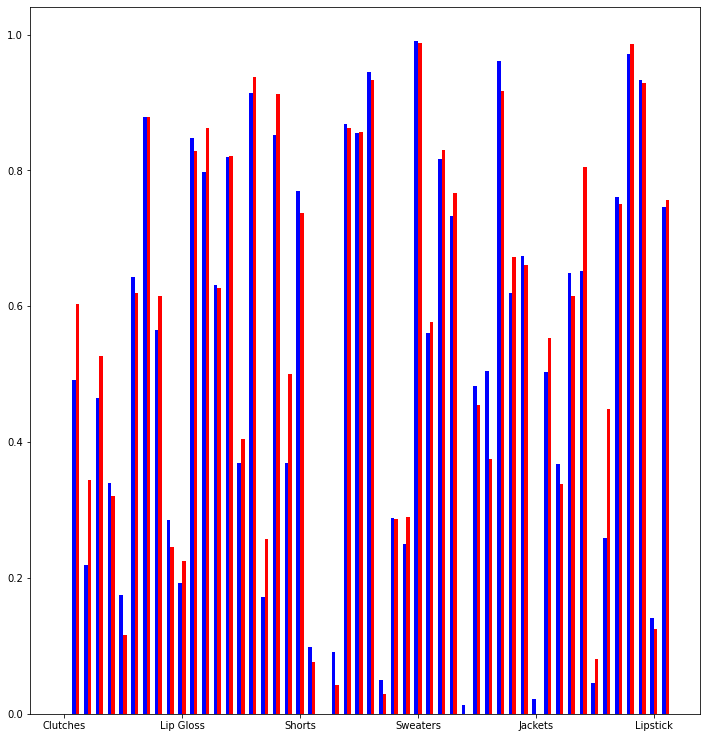

epoch 1, train_loss: 2.711, time elapsed: 11.290432 seconds
epoch 2, train_loss: 2.032, time elapsed: 11.326332 seconds
epoch 3, train_loss: 1.653, time elapsed: 11.278363 seconds
epoch 4, train_loss: 1.448, time elapsed: 11.322772 seconds
epoch 5, train_loss: 1.341, time elapsed: 11.252767 seconds
epoch 6, train_loss: 1.257, time elapsed: 11.329072 seconds
epoch 7, train_loss: 1.185, time elapsed: 11.29631 seconds
epoch 8, train_loss: 1.128, time elapsed: 11.292939 seconds
epoch 9, train_loss: 1.082, time elapsed: 11.28943 seconds
epoch 10, train_loss: 1.044, time elapsed: 11.437354 seconds
total training time: 1.885 minutes
batch size =  128  learning rate =  0.06
>>>>>>>>total accuracy on train data is 0.663 and on test data is 0.657


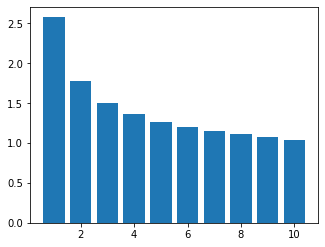

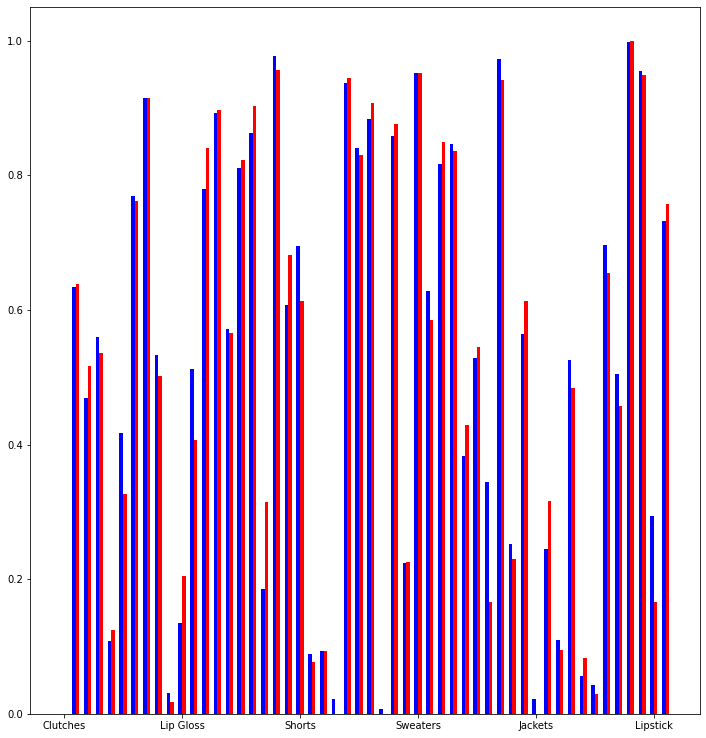

epoch 1, train_loss: 2.852, time elapsed: 11.169207 seconds
epoch 2, train_loss: 2.075, time elapsed: 11.204134 seconds
epoch 3, train_loss: 1.767, time elapsed: 11.092854 seconds
epoch 4, train_loss: 1.580, time elapsed: 11.196696 seconds
epoch 5, train_loss: 1.451, time elapsed: 11.25307 seconds
epoch 6, train_loss: 1.370, time elapsed: 11.143916 seconds
epoch 7, train_loss: 1.307, time elapsed: 11.343968 seconds
epoch 8, train_loss: 1.240, time elapsed: 11.167258 seconds
epoch 9, train_loss: 1.195, time elapsed: 11.114432 seconds
epoch 10, train_loss: 1.160, time elapsed: 11.133247 seconds
total training time: 1.864 minutes
batch size =  128  learning rate =  0.02
>>>>>>>>total accuracy on train data is 0.729 and on test data is 0.729


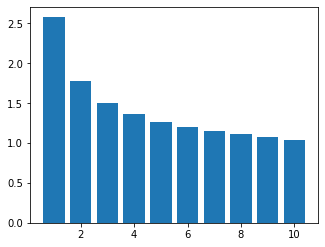

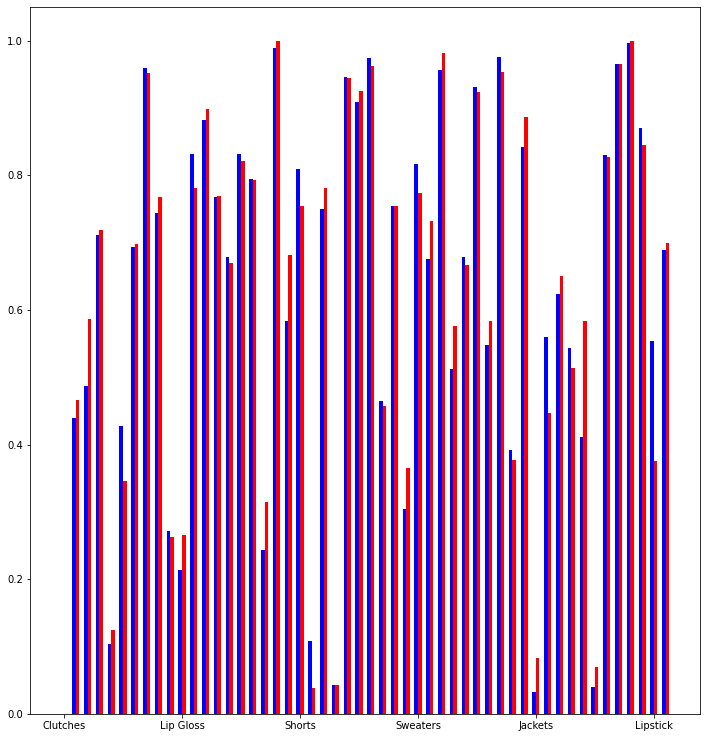

In [25]:
norm_transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor()
                               ])
dataset = ImgDS(data_path, norm_transform)
n_classes = dataset.n_classes

train_indices, test_indices = get_train_test_indices(dataset)

train_data_loader32 = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_indices), drop_last=True)
test_data_loader32 = DataLoader(Subset(dataset, test_indices), batch_size=32, drop_last=False)

train_data_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices), drop_last=True)
test_data_loader = DataLoader(Subset(dataset, test_indices), batch_size=batch_size, drop_last=False)

train_data_loader128 = DataLoader(dataset, batch_size=128, sampler=SubsetRandomSampler(train_indices), drop_last=True)
test_data_loader128 = DataLoader(Subset(dataset, test_indices), batch_size=128, drop_last=False)

#-------------------------------------------------------------------------------batch_size = 32
model7 = Feedforward_net([4800, 12000, 7200, 52])

optimizer7 = torch.optim.SGD(model7.parameters(), lr=0.04)
model7 = model7.to(device)
losses7 = train(model7, optimizer7, train_data_loader32)

print('batch size = ', 32, ' learning rate = ', 0.04)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model7)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses2)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------batch_size = 128
model7 = Feedforward_net([4800, 12000, 7200, 52])

optimizer7 = torch.optim.SGD(model7.parameters(), lr=0.04)
model7 = model7.to(device)
losses7 = train(model7, optimizer7, train_data_loader128)

print('batch size = ', 128, ' learning rate = ', 0.04)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model7)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses2)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------batch_size = 128, lr = 0.06
model7 = Feedforward_net([4800, 2400, 2400, 52])

optimizer7 = torch.optim.SGD(model7.parameters(), lr=0.06)
model7 = model7.to(device)
losses7 = train(model7, optimizer7, train_data_loader128)

print('batch size = ', 128, ' learning rate = ', 0.06)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model7)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses2)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------batch_size = 128, lr = 0.02
model7 = Feedforward_net([4800, 2400, 2400, 52])

optimizer7 = torch.optim.SGD(model7.parameters(), lr=0.02)
model7 = model7.to(device)
losses7 = train(model7, optimizer7, train_data_loader128)

print('batch size = ', 128, ' learning rate = ', 0.02)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model6)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses2)
plot_per_class_accuracy(train_accuracies, test_accuracies)


# Part8:
## Momentum:
Through this approach, gradient used in update learning rule is not completely replaced by new computed gradient and it is a weighted average of both the previsous gradient we used in update rule and the new computed gradient, so with this approach, always when we update weights we have a weighted sum of all of calculated gradients on each step till now where the weights of older gradients decays exponentially. All of these causes the update term calculated on each step does not make a rapid change and always a constant percent of its value is the last value it had before.

Pros: We can say that this approach can cause small gradients to not speed down the learning process and also can cause the noisy gradients to not disturb the learning process so much. I think both of these plus points can cause the model converge earlier.

Cons: The only drawback about this approach comes to my mind is that, it causes the model to be more complex and adds some complexity to our model.

Result Analysis: As we observe in accuracies we got, we can easlily see that moemntum does not always improve the model but it can destroy its performance with momentum of 0.5 we see a little improvement but with momentum of 0.9 and 0.98 we see degradation in the accuracy the output model has.

epoch 1, train_loss: 2.199, time elapsed: 18.339873 seconds
epoch 2, train_loss: 1.504, time elapsed: 18.395926 seconds
epoch 3, train_loss: 1.299, time elapsed: 18.364459 seconds
epoch 4, train_loss: 1.183, time elapsed: 18.41198 seconds
epoch 5, train_loss: 1.098, time elapsed: 18.346642 seconds
epoch 6, train_loss: 1.031, time elapsed: 18.567468 seconds
epoch 7, train_loss: 0.979, time elapsed: 18.397177 seconds
epoch 8, train_loss: 0.937, time elapsed: 18.360434 seconds
epoch 9, train_loss: 0.901, time elapsed: 18.467879 seconds
epoch 10, train_loss: 0.868, time elapsed: 18.433012 seconds
total training time: 3.068 minutes
learning_rate =  0.04 momentum =  0
>>>>>>>>total accuracy on train data is 0.692 and on test data is 0.695


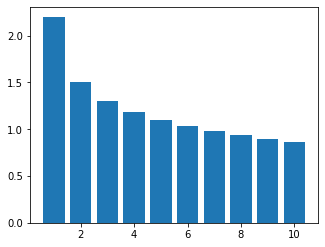

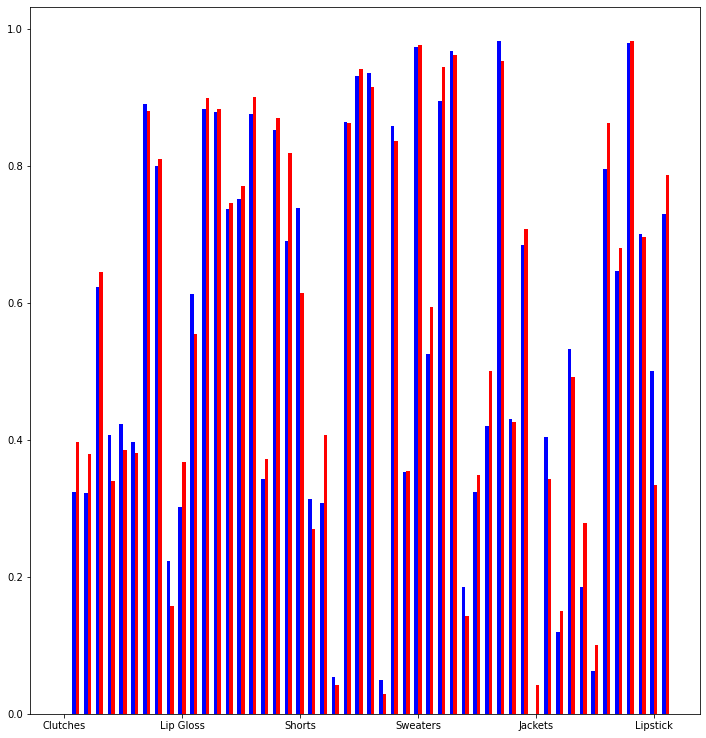

epoch 1, train_loss: 2.024, time elapsed: 20.855594 seconds
epoch 2, train_loss: 1.369, time elapsed: 20.87544 seconds
epoch 3, train_loss: 1.211, time elapsed: 20.880958 seconds
epoch 4, train_loss: 1.093, time elapsed: 20.880324 seconds
epoch 5, train_loss: 1.022, time elapsed: 20.782625 seconds
epoch 6, train_loss: 0.960, time elapsed: 20.728691 seconds
epoch 7, train_loss: 0.916, time elapsed: 20.889578 seconds
epoch 8, train_loss: 0.876, time elapsed: 20.962155 seconds
epoch 9, train_loss: 0.852, time elapsed: 20.760558 seconds
epoch 10, train_loss: 0.817, time elapsed: 20.862257 seconds
total training time: 3.475 minutes
learning_rate =  0.04 momentum =  0.5
>>>>>>>>total accuracy on train data is 0.744 and on test data is 0.749


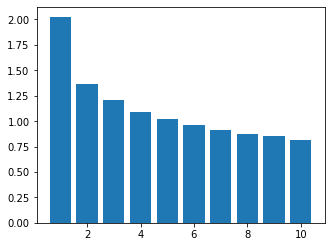

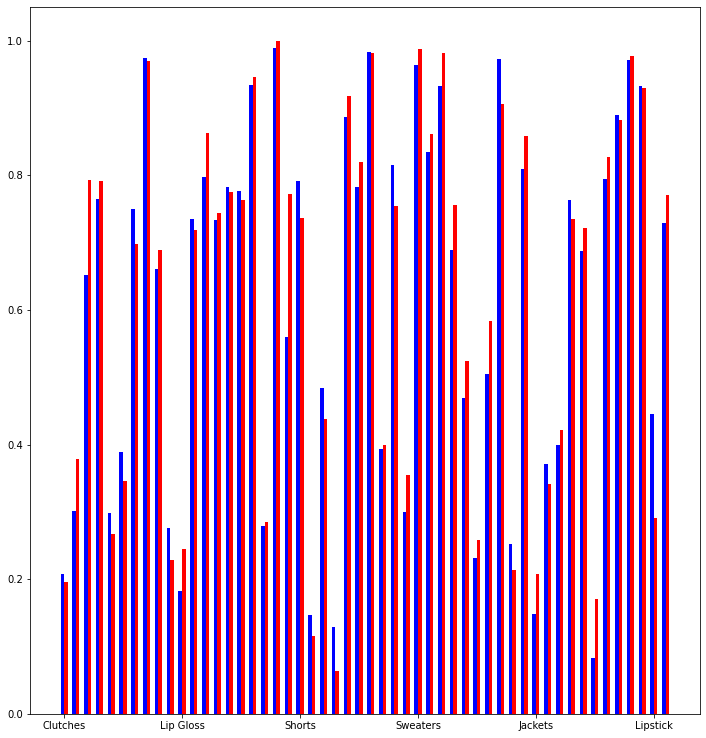

epoch 1, train_loss: 2.722, time elapsed: 20.551612 seconds
epoch 2, train_loss: 2.515, time elapsed: 20.55577 seconds
epoch 3, train_loss: 2.580, time elapsed: 20.685777 seconds
epoch 4, train_loss: 2.799, time elapsed: 20.505182 seconds
epoch 5, train_loss: 3.465, time elapsed: 20.516623 seconds
epoch 6, train_loss: 3.452, time elapsed: 20.550713 seconds
epoch 7, train_loss: 3.451, time elapsed: 20.462477 seconds
epoch 8, train_loss: 3.450, time elapsed: 20.5975 seconds
epoch 9, train_loss: 3.451, time elapsed: 20.474397 seconds
epoch 10, train_loss: 3.451, time elapsed: 20.473467 seconds
total training time: 3.423 minutes
learning_rate =  0.04 momentum =  0.9
>>>>>>>>total accuracy on train data is 0.095 and on test data is 0.095


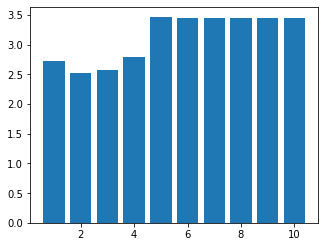

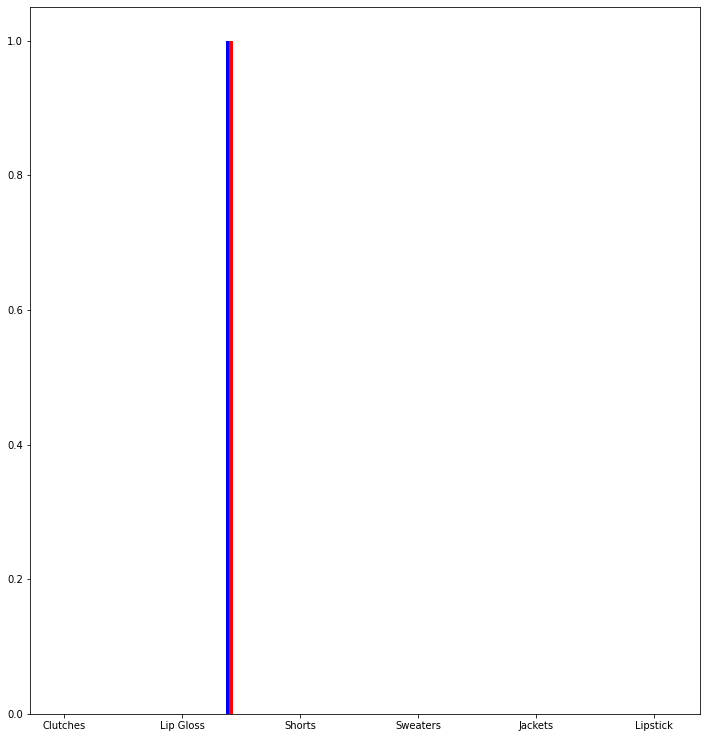

epoch 1, train_loss: 3.581, time elapsed: 20.490156 seconds
epoch 2, train_loss: 3.461, time elapsed: 20.345335 seconds
epoch 3, train_loss: 3.458, time elapsed: 20.51311 seconds
epoch 4, train_loss: 3.458, time elapsed: 20.427139 seconds
epoch 5, train_loss: 3.457, time elapsed: 20.633465 seconds
epoch 6, train_loss: 3.450, time elapsed: 20.576022 seconds
epoch 7, train_loss: 3.448, time elapsed: 20.692505 seconds
epoch 8, train_loss: 3.447, time elapsed: 20.553937 seconds
epoch 9, train_loss: 3.456, time elapsed: 20.598142 seconds
epoch 10, train_loss: 3.457, time elapsed: 20.39227 seconds
total training time: 3.420 minutes
learning_rate =  0.04 momentum =  0.98
>>>>>>>>total accuracy on train data is 0.065 and on test data is 0.064


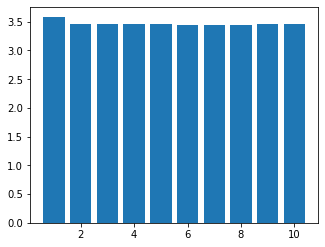

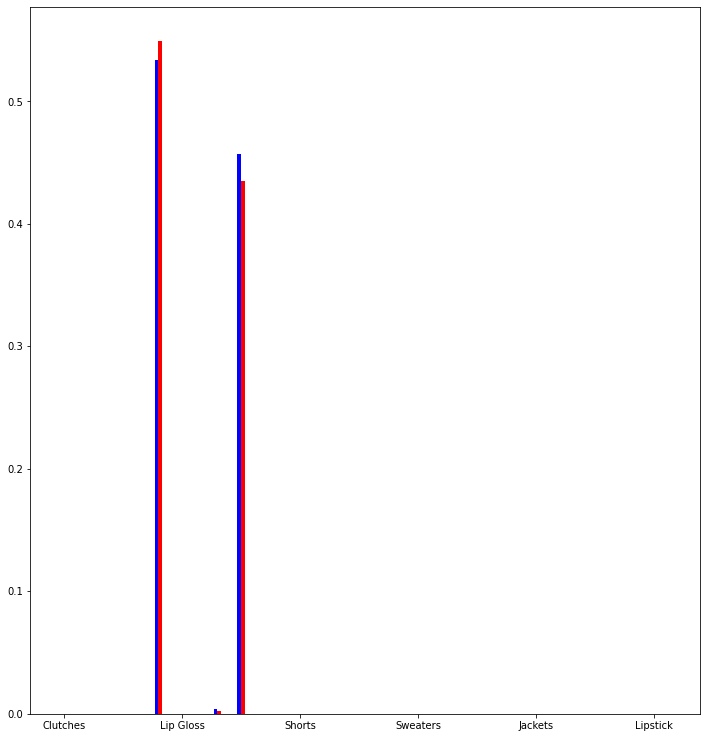

In [26]:
model8 = Feedforward_net([4800, 12000, 7200, 52])

optimizer8 = torch.optim.SGD(model8.parameters(), lr=0.04)
model8 = model8.to(device)
losses8 = train(model8, optimizer8, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model8)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses8)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------
model8 = Feedforward_net([4800, 12000, 7200, 52])

optimizer8 = torch.optim.SGD(model8.parameters(), lr=0.04, momentum=0.5)
model8 = model8.to(device)
losses8 = train(model8, optimizer8, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0.5)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model8)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses8)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------
model8 = Feedforward_net([4800, 12000, 7200, 52])

optimizer8 = torch.optim.SGD(model8.parameters(), lr=0.04, momentum=0.9)
model8 = model8.to(device)
losses8 = train(model8, optimizer8, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0.9)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model8)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses8)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------
model8 = Feedforward_net([4800, 12000, 7200, 52])

optimizer8 = torch.optim.SGD(model8.parameters(), lr=0.04, momentum=0.98)
model8 = model8.to(device)
losses8 = train(model8, optimizer8, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0.98)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model8)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses8)
plot_per_class_accuracy(train_accuracies, test_accuracies)


# Part9:
Epoch 20: With the epoch of 20 we could get better accuracy compared to model trained in 10 epochs, and the accuracy increased about 5% and also the train and test accuracy both are high and do not differ which means that the model is not overfitted.

Why Epochs: Almost always in training process of a model we train the model for several epochs on the whole train data, because with iterating over data on each epoch the model sees one time all of the data and try to fit to the data and with the repeatation of this process we allow the model to perform this progressive process for several times and be able to fit the both train and test better.

Increase Epochs: Generally increasing epoch cause the model to better fit the train data but this procedure can also cause the model to be overfitted on train data and lose its generalization and work bad on test data, so we have to make a balance in this trade off and consider that higher number of epochs can cause the model to be overfitted.




epoch 1, train_loss: 1.970, time elapsed: 20.621869 seconds
epoch 2, train_loss: 1.400, time elapsed: 20.614276 seconds
epoch 3, train_loss: 1.251, time elapsed: 20.570274 seconds
epoch 4, train_loss: 1.115, time elapsed: 20.539565 seconds
epoch 5, train_loss: 1.042, time elapsed: 20.646694 seconds
epoch 6, train_loss: 0.976, time elapsed: 20.76311 seconds
epoch 7, train_loss: 0.922, time elapsed: 20.71033 seconds
epoch 8, train_loss: 0.879, time elapsed: 20.630731 seconds
epoch 9, train_loss: 0.847, time elapsed: 20.682474 seconds
epoch 10, train_loss: 0.823, time elapsed: 20.718539 seconds
total training time: 3.442 minutes
learning_rate =  0.04 momentum =  0.5 epoch =  10
>>>>>>>>total accuracy on train data is 0.730 and on test data is 0.734


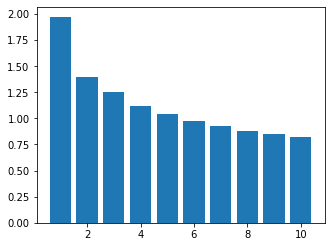

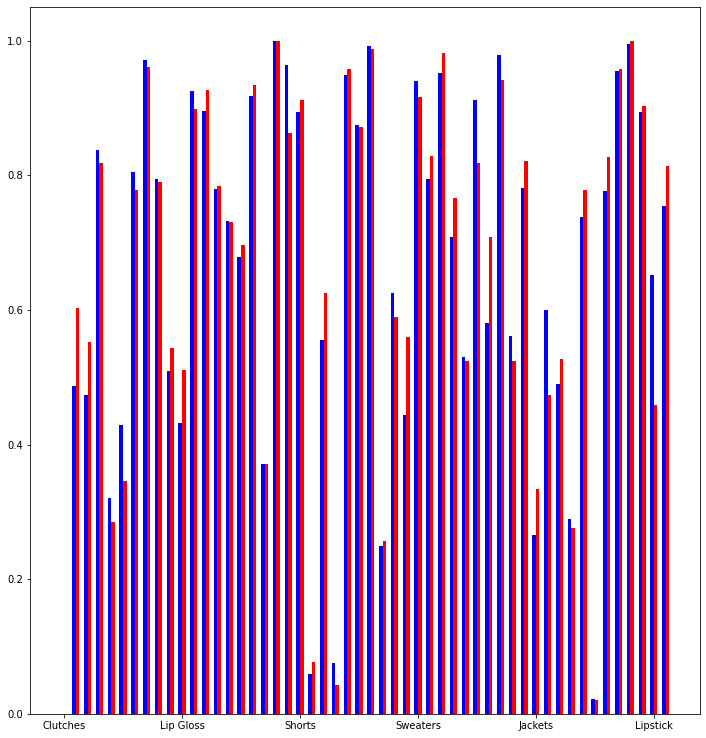

epoch 1, train_loss: 2.010, time elapsed: 20.808992 seconds
epoch 2, train_loss: 1.396, time elapsed: 20.822829 seconds
epoch 3, train_loss: 1.213, time elapsed: 20.920493 seconds
epoch 4, train_loss: 1.092, time elapsed: 20.818779 seconds
epoch 5, train_loss: 1.027, time elapsed: 20.829354 seconds
epoch 6, train_loss: 0.965, time elapsed: 20.84437 seconds
epoch 7, train_loss: 0.903, time elapsed: 20.963028 seconds
epoch 8, train_loss: 0.876, time elapsed: 20.870588 seconds
epoch 9, train_loss: 0.840, time elapsed: 20.93223 seconds
epoch 10, train_loss: 0.809, time elapsed: 20.992545 seconds
epoch 11, train_loss: 0.784, time elapsed: 20.894067 seconds
epoch 12, train_loss: 0.762, time elapsed: 20.871687 seconds
epoch 13, train_loss: 0.738, time elapsed: 20.897131 seconds
epoch 14, train_loss: 0.715, time elapsed: 20.926055 seconds
epoch 15, train_loss: 0.694, time elapsed: 21.052354 seconds
epoch 16, train_loss: 0.672, time elapsed: 20.892993 seconds
epoch 17, train_loss: 0.653, time e

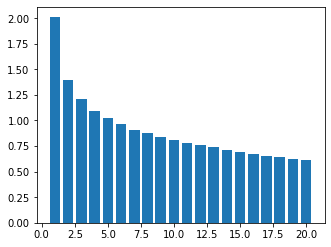

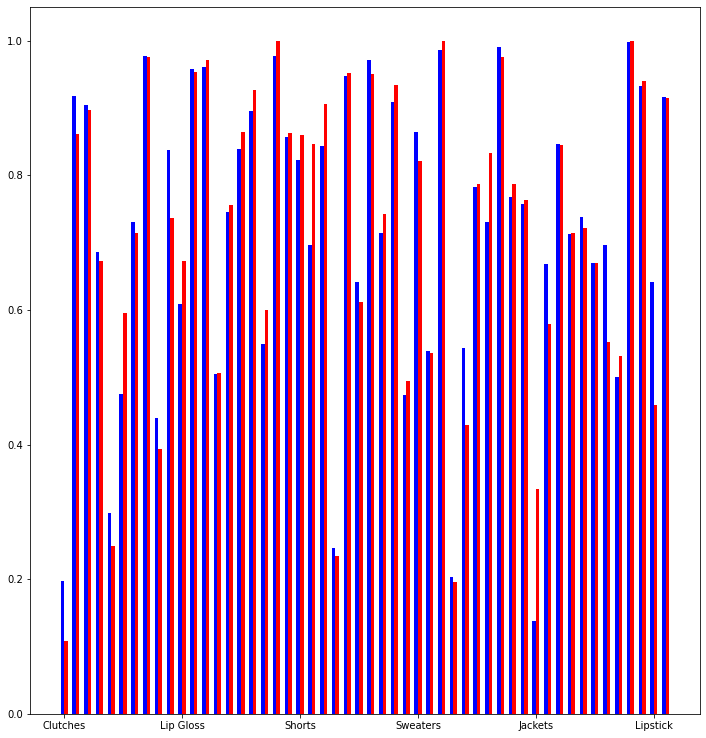

In [27]:
model9 = Feedforward_net([4800, 12000, 7200, 52])

optimizer9 = torch.optim.SGD(model9.parameters(), lr=0.04, momentum=0.5)
model9 = model9.to(device)
losses9 = train(model9, optimizer9, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0.5, 'epoch = ', 10)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model9)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses9)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------
model9 = Feedforward_net([4800, 12000, 7200, 52])

optimizer9 = torch.optim.SGD(model9.parameters(), lr=0.04, momentum=0.5)
model9 = model9.to(device)
losses9 = train(model9, optimizer9, train_data_loader, n_epoch=20)

print('learning_rate = ', 0.04, 'momentum = ', 0.5, 'epoch = ', 20)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model9)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses9)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# Part10:
## Activation Functions:
We see almost the same accuracy on leakyRelu and a so much bad accuracy with tanh activation function which worked too bad in this model.

## LeakyRelu:
This kind of activation function is like the relu function with a difference on its below zero values, as it has a very low slope and so its values is not zero for x's under zero.

## tanh:
This is a function changes from -1 to 1 in a symmetric way and the function increases mostly near zero and for other x's further from zero the values changes little.

epoch 1, train_loss: 2.008, time elapsed: 20.61795 seconds
epoch 2, train_loss: 1.358, time elapsed: 20.524112 seconds
epoch 3, train_loss: 1.197, time elapsed: 20.687329 seconds
epoch 4, train_loss: 1.086, time elapsed: 20.732245 seconds
epoch 5, train_loss: 1.028, time elapsed: 20.698867 seconds
epoch 6, train_loss: 0.964, time elapsed: 20.56647 seconds
epoch 7, train_loss: 0.908, time elapsed: 20.509051 seconds
epoch 8, train_loss: 0.885, time elapsed: 20.503351 seconds
epoch 9, train_loss: 0.837, time elapsed: 20.752385 seconds
epoch 10, train_loss: 0.818, time elapsed: 20.594366 seconds
total training time: 3.436 minutes
learning_rate =  0.04 momentum =  0.5 epoch =  10 activation =  leakyRelu
>>>>>>>>total accuracy on train data is 0.757 and on test data is 0.764


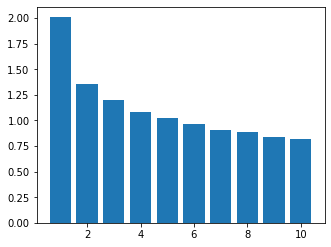

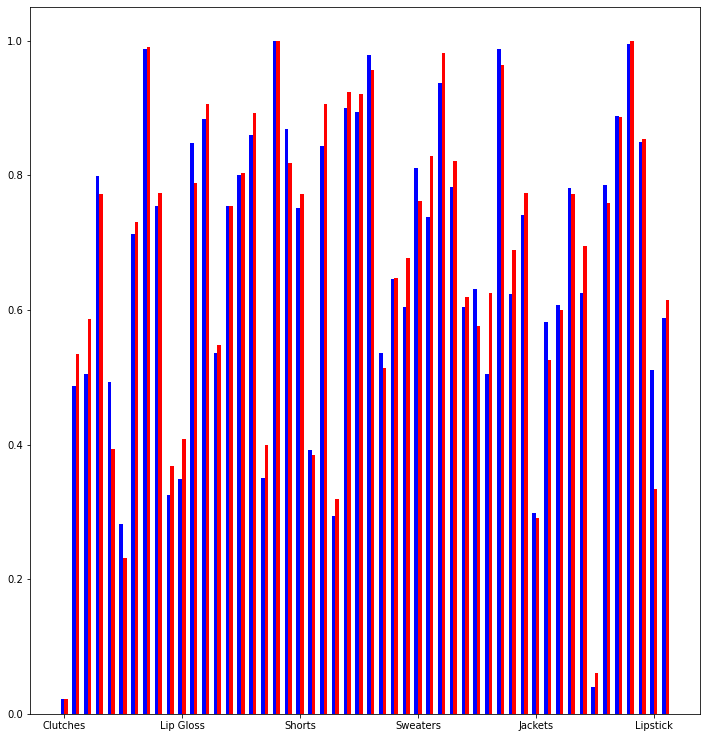

epoch 1, train_loss: 214.704, time elapsed: 20.48749 seconds
epoch 2, train_loss: 241.026, time elapsed: 20.505379 seconds
epoch 3, train_loss: 239.060, time elapsed: 20.397382 seconds
epoch 4, train_loss: 239.888, time elapsed: 20.518132 seconds
epoch 5, train_loss: 236.362, time elapsed: 20.556286 seconds
epoch 6, train_loss: 241.648, time elapsed: 20.455485 seconds
epoch 7, train_loss: 241.394, time elapsed: 20.621481 seconds
epoch 8, train_loss: 237.424, time elapsed: 20.428225 seconds
epoch 9, train_loss: 241.638, time elapsed: 20.367037 seconds
epoch 10, train_loss: 240.838, time elapsed: 20.498429 seconds
total training time: 3.414 minutes
learning_rate =  0.04 momentum =  0.5 epoch =  10 activation =  tanh
>>>>>>>>total accuracy on train data is 0.055 and on test data is 0.054


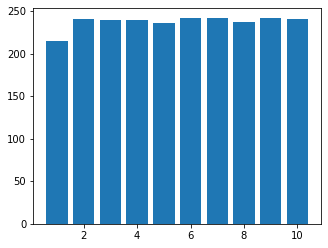

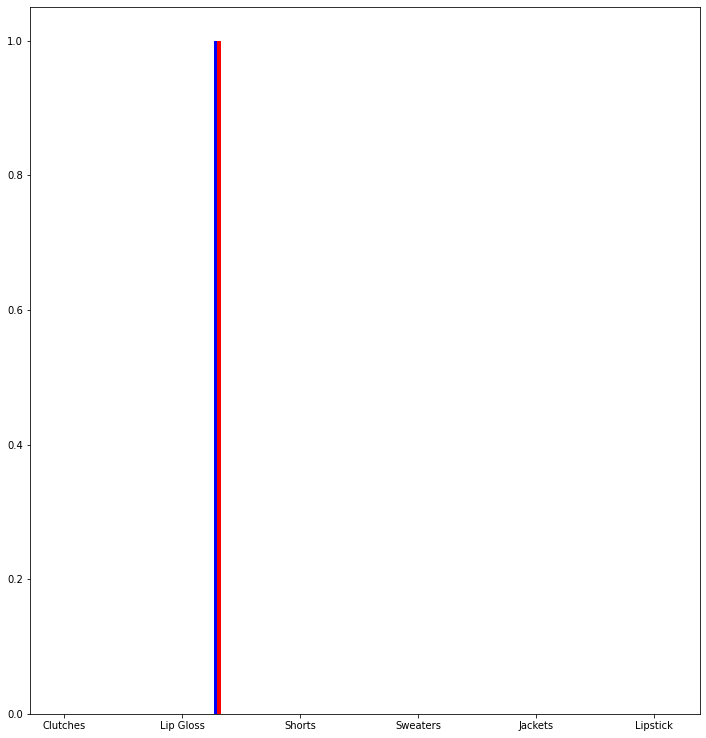

In [28]:
model10 = Feedforward_net([4800, 12000, 7200, 52], activation='leakyRelu')

optimizer10 = torch.optim.SGD(model10.parameters(), lr=0.04, momentum=0.5)
model10 = model10.to(device)
losses10 = train(model10, optimizer10, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0.5, 'epoch = ', 10, 'activation = ', 'leakyRelu')
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model10)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses10)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------
model10 = Feedforward_net([4800, 12000, 7200, 52], activation='tanh')

optimizer10 = torch.optim.SGD(model10.parameters(), lr=0.04, momentum=0.5)
model10 = model10.to(device)
losses10 = train(model10, optimizer10, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0.5, 'epoch = ', 10, 'activation = ', 'tanh')
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model10)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses10)
plot_per_class_accuracy(train_accuracies, test_accuracies)

# Part11:
Loss Term: We know the loss term added to the loss function is always a larger equal than zero function of weights of the model that causes the loss value to be a sum of consistency of model on data error and complexity of the model. Adding this term to the loss function helps us prevent overfitting as it controls the complexity of the model by having for example L1 or L2 norm of model weights.

Weight Decay: Weight decay factor adds an L2-norm penalty to the weights of the model which simply causes the model have smaller weights and causes the model to be regularized through this method.

Result: Weight decay of 0.1 causes our model to get a low accuracy and I think this is result of the fact that the model has been high biased so it has lost its consistency.

epoch 1, train_loss: 2.618, time elapsed: 22.043041 seconds
epoch 2, train_loss: 2.460, time elapsed: 22.136463 seconds
epoch 3, train_loss: 2.460, time elapsed: 22.163217 seconds
epoch 4, train_loss: 2.462, time elapsed: 22.029454 seconds
epoch 5, train_loss: 2.451, time elapsed: 22.076269 seconds
epoch 6, train_loss: 2.449, time elapsed: 22.038128 seconds
epoch 7, train_loss: 2.442, time elapsed: 22.232026 seconds
epoch 8, train_loss: 2.500, time elapsed: 22.12851 seconds
epoch 9, train_loss: 2.447, time elapsed: 22.192678 seconds
epoch 10, train_loss: 2.478, time elapsed: 22.292567 seconds
total training time: 3.689 minutes
learning_rate =  0.04 momentum =  0.5 epoch =  10
>>>>>>>>total accuracy on train data is 0.304 and on test data is 0.303


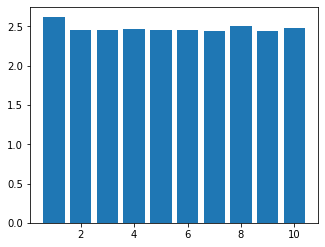

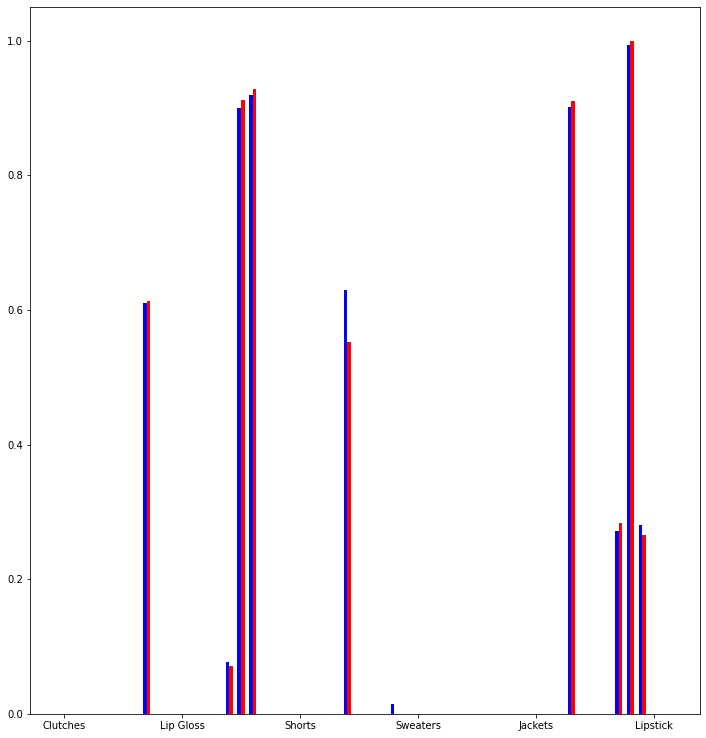

epoch 1, train_loss: 2.085, time elapsed: 21.983552 seconds
epoch 2, train_loss: 1.539, time elapsed: 22.025322 seconds
epoch 3, train_loss: 1.443, time elapsed: 22.034209 seconds
epoch 4, train_loss: 1.392, time elapsed: 22.028247 seconds
epoch 5, train_loss: 1.391, time elapsed: 22.100661 seconds
epoch 6, train_loss: 1.364, time elapsed: 22.087846 seconds
epoch 7, train_loss: 1.337, time elapsed: 22.079068 seconds
epoch 8, train_loss: 1.338, time elapsed: 21.968717 seconds
epoch 9, train_loss: 1.311, time elapsed: 22.00602 seconds
epoch 10, train_loss: 1.310, time elapsed: 22.037881 seconds
total training time: 3.673 minutes
learning_rate =  0.04 momentum =  0.5 epoch =  10
>>>>>>>>total accuracy on train data is 0.586 and on test data is 0.589


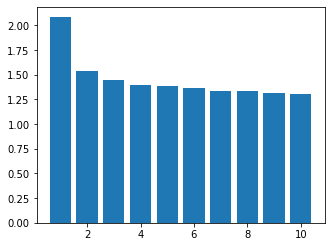

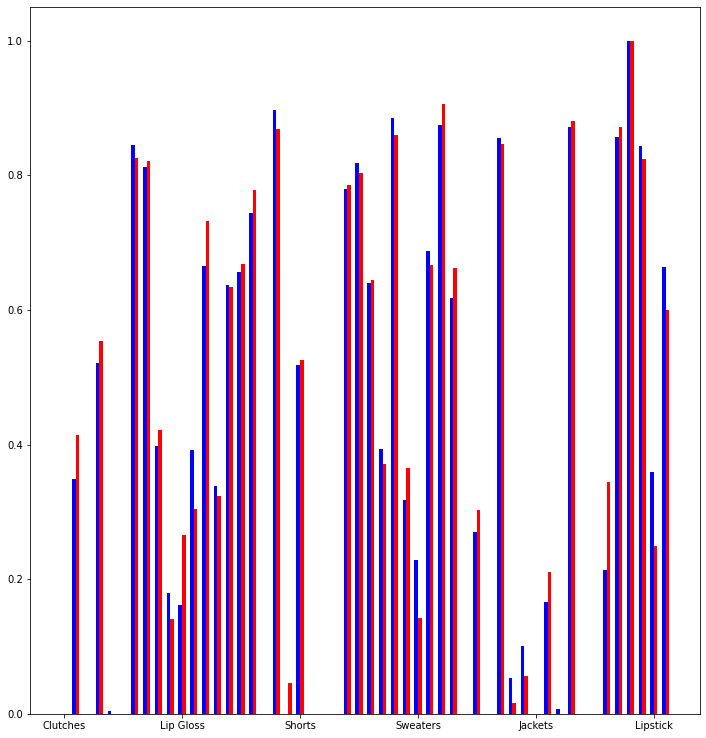

In [29]:
model11 = Feedforward_net([4800, 12000, 7200, 52])

optimizer11 = torch.optim.SGD(model11.parameters(), lr=0.04, momentum=0.5, weight_decay=0.1)
model11 = model11.to(device)
losses11 = train(model11, optimizer11, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0.5, 'epoch = ', 10)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model11)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses11)
plot_per_class_accuracy(train_accuracies, test_accuracies)

#-------------------------------------------------------------------------------
model11 = Feedforward_net([4800, 12000, 7200, 52])

optimizer11 = torch.optim.SGD(model11.parameters(), lr=0.04, momentum=0.5, weight_decay=0.01)
model11 = model11.to(device)
losses11 = train(model11, optimizer11, train_data_loader)

print('learning_rate = ', 0.04, 'momentum = ', 0.5, 'epoch = ', 10)
train_total_accuracy, test_total_accuracy, train_accuracies, test_accuracies, trcm, tecm = get_per_class_accuracy(model11)
print('>>>>>>>>total accuracy on train data is %.3f and on test data is %.3f' %(train_total_accuracy, test_total_accuracy))
plot_train_losses(losses11)
plot_per_class_accuracy(train_accuracies, test_accuracies)